In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
start_date = datetime.datetime(2017, 1, 1)
end_date = datetime.datetime(2022, 1, 1)

tickers = ["NFLX", "TSLA", "AMD", "^IXIC"]

# inverval="m" gives monthly returns
data = web.get_data_yahoo(tickers, start_date, end_date, interval="m")

In [3]:
data = data["Adj Close"]
print(data.tail())

Symbols           NFLX         TSLA         AMD         ^IXIC
Date                                                         
2021-09-01  610.340027   775.479980  102.900002  14448.580078
2021-10-01  690.309998  1114.000000  120.230003  15498.389648
2021-11-01  641.900024  1144.760010  158.369995  15537.690430
2021-12-01  602.440002  1056.780029  143.899994  15644.969727
2022-01-01  427.140015   936.719971  114.250000  14239.879883


In [4]:
log_returns = np.log(data/data.shift(1))
log_returns = log_returns.dropna(axis=0)
print(log_returns.tail())

Symbols         NFLX      TSLA       AMD     ^IXIC
Date                                              
2021-09-01  0.069802  0.052633 -0.073247 -0.054589
2021-10-01  0.123125  0.362230  0.155649  0.070140
2021-11-01 -0.072708  0.027238  0.275527  0.002533
2021-12-01 -0.063444 -0.079968 -0.095815  0.006881
2022-01-01 -0.343876 -0.120597 -0.230730 -0.094103


# How to calculate the beta of a security?

`Beta = Covariance / Variance`

* Covariance: Measure of a stock's return relative to that of the market

* Variance: Measure of how the market moves relative to its mean

In [5]:
def get_beta(df:pd.DataFrame, stock_tic:str, index_tic:str):

  """df: Dataframe: log_returns with tickers as columns

    stock_tic: usually a particular stock's log normal returns
    
    index_tic: index, log normal returns of Nasdaq or S&P 500
    
    returns None
  """
  cov = df.cov()
  var = df[index_tic].var()

  print(cov)
  print("\nMarket Variance:", var)

  beta_netflix = cov.loc[stock_tic, index_tic]/var
  print(f"{stock_tic} beta: {beta_netflix}")


In [6]:
get_beta(log_returns, "NFLX", "^IXIC")

Symbols      NFLX      TSLA       AMD     ^IXIC
Symbols                                        
NFLX     0.010442  0.004935  0.007684  0.003048
TSLA     0.004935  0.030012  0.005419  0.004804
AMD      0.007684  0.005419  0.024949  0.004901
^IXIC    0.003048  0.004804  0.004901  0.002611

Market Variance: 0.0026112725925980995
NFLX beta: 1.1674078433399673


# Using Linear Regression to calculate the beta

In [30]:
def linear_regression_model(df, stock_tic, index_tic):
  """df: dataframe: log_returns with tickers as columns

    stock_tic: usually a particular stock's log normal returns
    
    index_tic: index, log normal returns of Nasdaq or S&P 500
    
    returns None
  """
  # .reshape(-1 means infere the length of the array, 1 means every item in the list is a list of length 1)
  # [[192], [21], [149]]
  Y = df[stock_tic].to_numpy().reshape(-1, 1)
  X = df[index_tic].to_numpy().reshape(-1, 1)
  # X: independent variable
  # Y: dependent variable

  lin_reg = LinearRegression()
  # Fit the data, train the model
  lin_reg.fit(X, Y)

  alpha = lin_reg.intercept_[0]  # Intercept
  beta = lin_reg.coef_[0, 0]  # Slope

  if alpha > 0:
    sign = "+"
  else: sign = "-"

  # print(f"Regression Line Equation: y = {round(beta, 4)}x {sign} {round(abs(alpha), 4)}")

  # Predict
  Y_predict = lin_reg.predict(X)

  # Model evaluation, quantify how well a regression model fits a dataset
  rmse = mean_squared_error(Y, Y_predict)
  r2 = r2_score(Y, Y_predict)

  data = [("Alpha:", alpha), ("Beta:", beta), ("Root mean squared error:", rmse), ("Coefficient of determination", r2)]


  for name, d in data:
    print(f"{name} {d:.5f}")

  # Plot a scatter graph
  fig, ax = plt.subplots()
  fig.suptitle(f"Linear Regression Model for {stock_tic} against {index_tic}")

  ax.set_title(f"Alpha: {round(alpha, 5)}, Beta: {round(beta, 3)}")

  ax.scatter(X, Y)
  
  ax.set_xlabel("Nasdaq Monthly LN Returns")
  ax.set_ylabel(f"{stock_tic} Monthly LN Returns")

  # Plot the line of best fit
  ax.plot(X, Y_predict, color="red")

  plt.tight_layout()
  plt.show()


Alpha: 0.00040                  
Beta: 1.16741                  
Root mean squared error: 0.00677                  
Coefficient of determination 0.34083                  


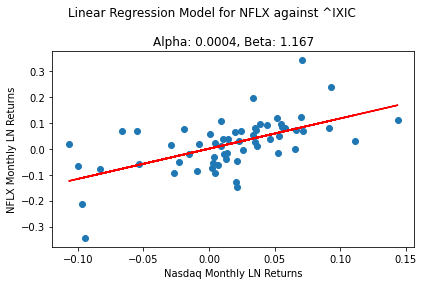

In [31]:
linear_regression_model(log_returns, "NFLX", "^IXIC")

## How to evaluate the linear regression model?

### Root Mean Square Error
RMSE: Lower values of RMSE indicate better fit.

### r^2: Coefficient of Determination
Shows the proportion of the variation in the dependent variable that is predictable from the independent variable.

Example: A r squared value of 30% shows that 30% of the data fit the regression model. It shows a weak to medium correlation between the independent variable and the dependent variable.

Regression Line Equation: y = 1.1674x + 0.0004
Alpha: 0.000399528127167717
Beta: 1.167407843339967
Root Mean Squared Error: 0.0067680650416461026
Coefficient of Determination: 0.340826524114215


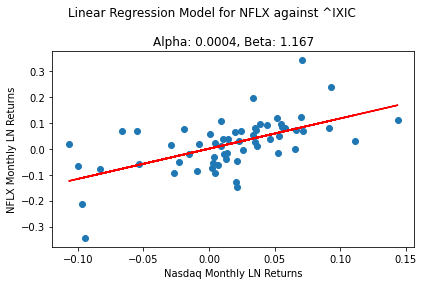

Regression Line Equation: y = 1.8396x + 0.0202
Alpha: 0.02017794112033015
Beta: 1.83958387315404
Root Mean Squared Error: 0.020822402334310663
Coefficient of Determination: 0.29443926707295787


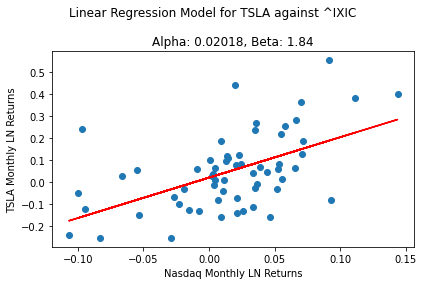

Regression Line Equation: y = 1.8769x + 0.0109
Alpha: 0.010879777861989348
Beta: 1.876860090774772
Root Mean Squared Error: 0.01548811567526399
Coefficient of Determination: 0.36868973082478684


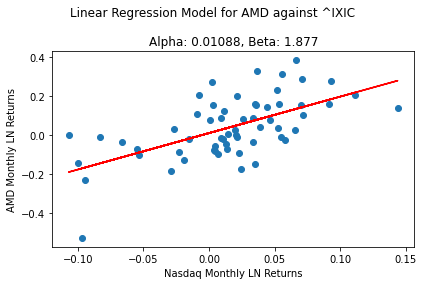

In [8]:
# Nasdaq or S&P 500
index_tic = tickers[-1]

for tic in tickers[:-1]:
  linear_regression_model(log_returns, tic, index_tic)